In [1]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from croissant.healpix import grid2healpix
import faraday as fd

#%matplotlib notebook

## Spectral Response

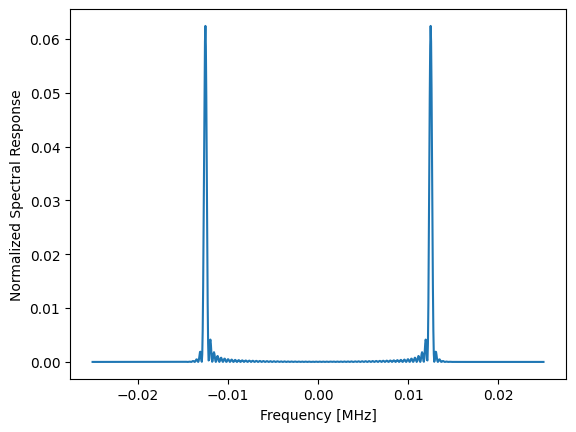

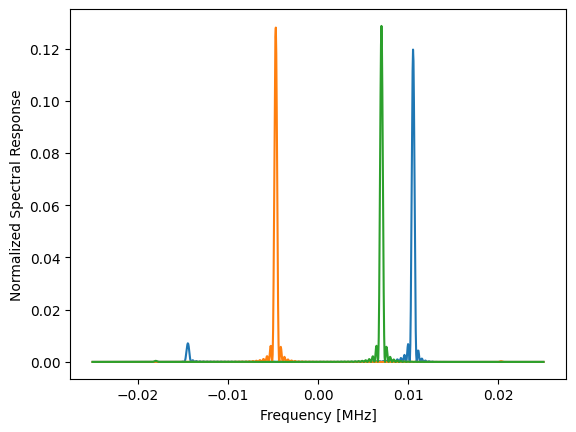

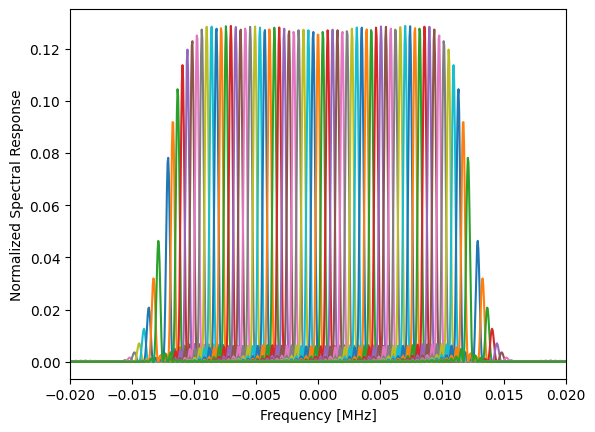

In [2]:
sim = fd.Simulator(None, None)

plt.figure()
plt.plot(sim.offset, sim.spec[:, 0])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(sim.offset, sim.spec[:, -5])
plt.plot(sim.offset, sim.spec[:, 20])
plt.plot(sim.offset, sim.spec[:, 50])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(sim.offset, sim.spec[:, 1:])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.xlim(-20/1e3, 20/1e3)
plt.show()

## Zenith Source

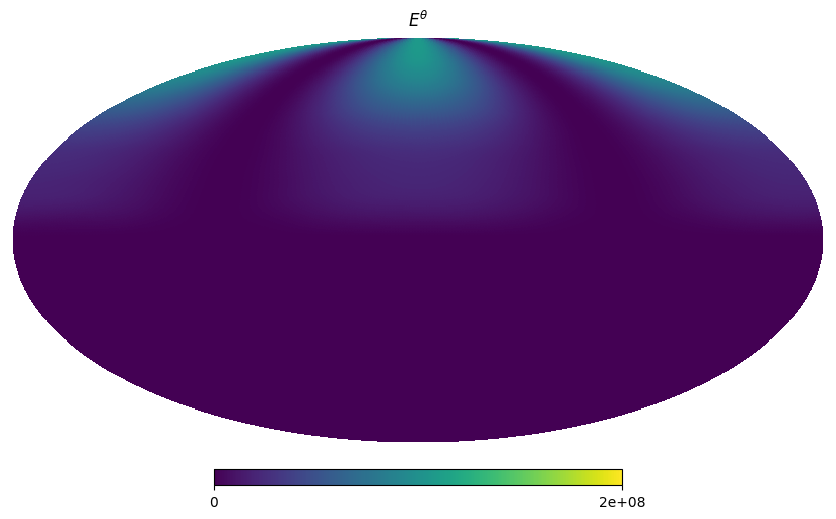

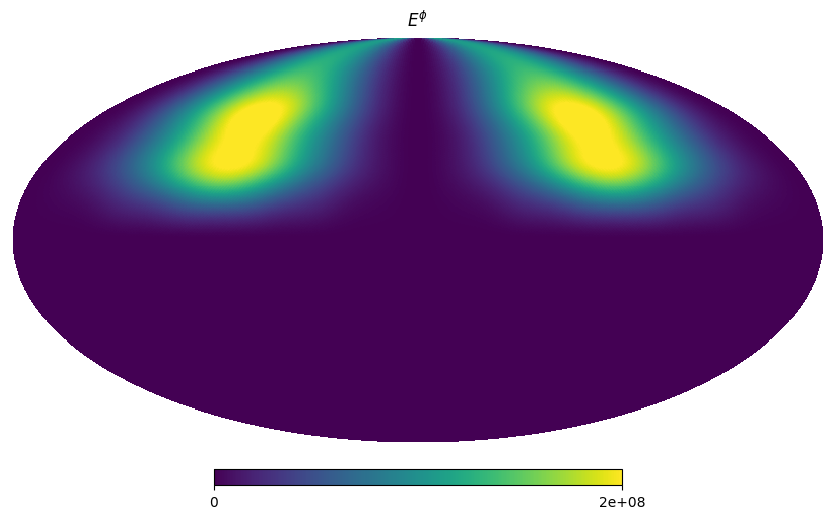

In [3]:
beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits", frequency=30)

hp.mollview(np.abs(beam.beam_X[0, 0])**2, title="$E^{\\theta}$", min=0, max=2e8)
plt.show()
hp.mollview(np.abs(beam.beam_X[1, 0])**2, title="$E^{\\phi}$", min=0, max=2e8)
plt.show()

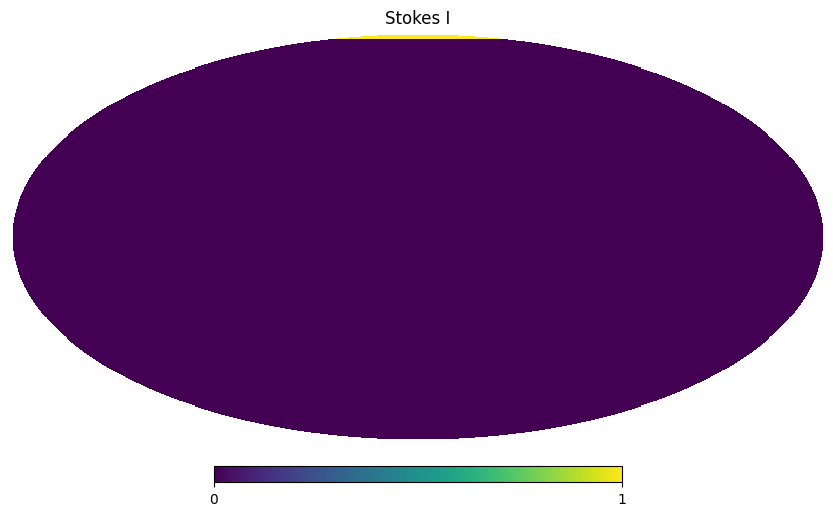

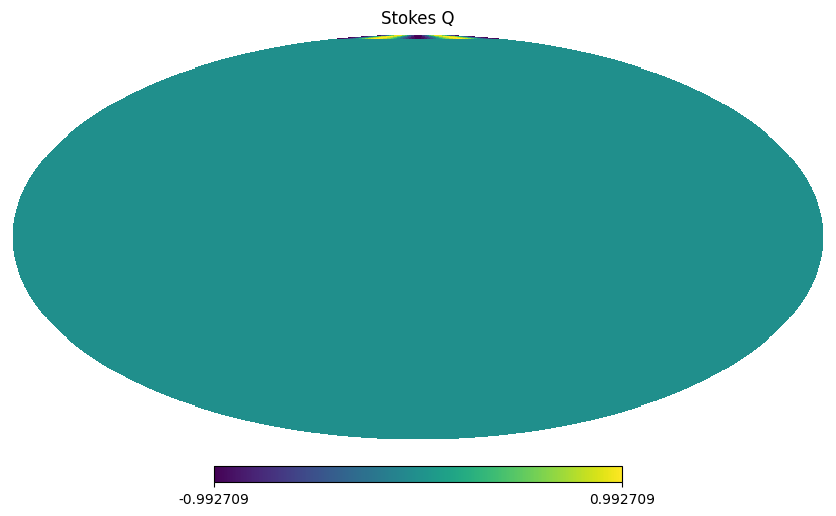

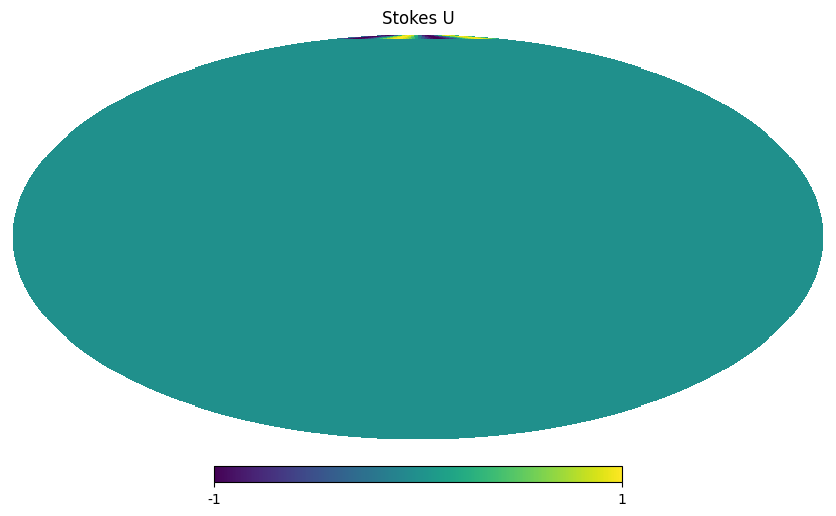

In [4]:
sky = fd.Sky.zeros()
sky.add_point_source()  # 5 deg source at zenith
hp.mollview(sky.stokes[0, 0], title="Stokes I")
plt.show()
hp.mollview(sky.stokes[1, 0], title="Stokes Q")
plt.show()
hp.mollview(sky.stokes[2, 0], title="Stokes U")
plt.show()

# simulator expects sky at 23 GHz, not 30 MHz
sky.stokes = sky.stokes * (23e3/30)**(-2.5)

_beam.beam_X.shape=(2, 1, 196608)
_beam.beam_X.shape=(2, 1, 364)


/home/christian/Documents/research/lusee/faraday/.venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


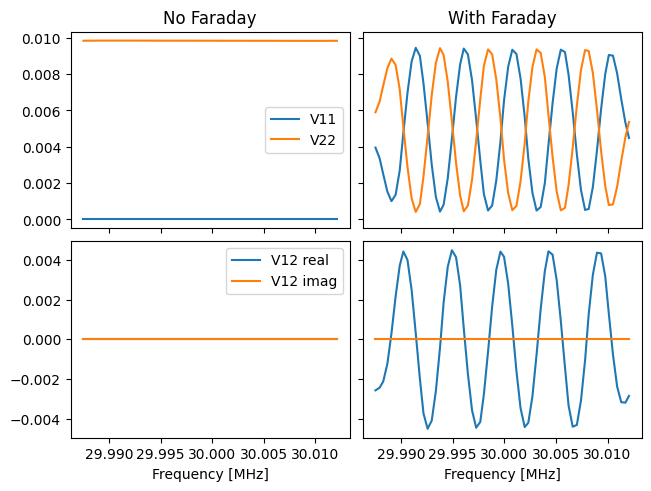

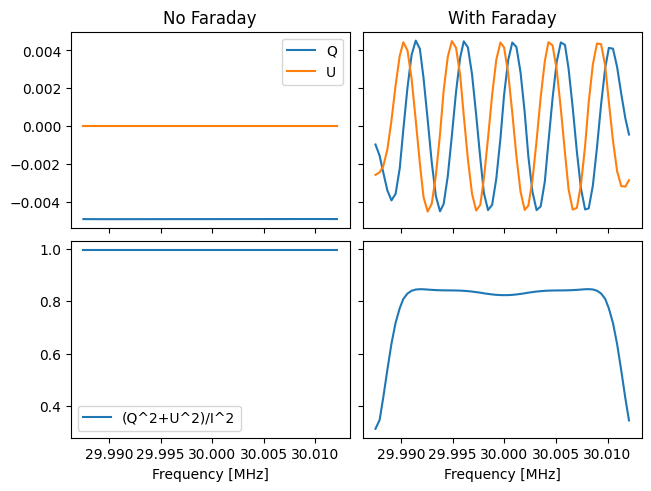

In [5]:
sim = fd.Simulator(beam, sky, full_map=False)
sim.run(channelize="narrow", src_frac=None)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

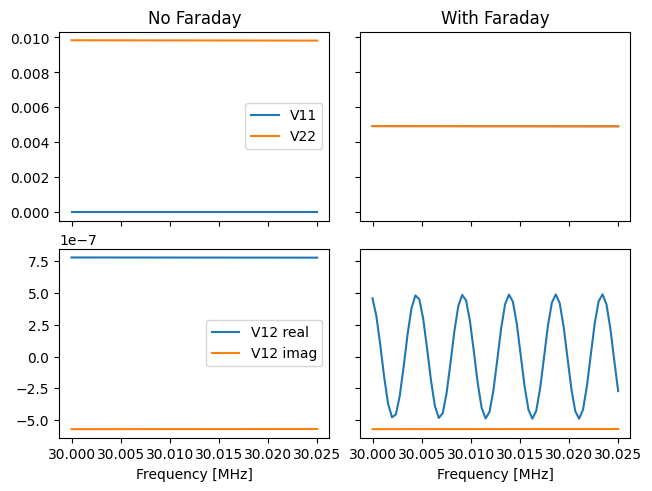

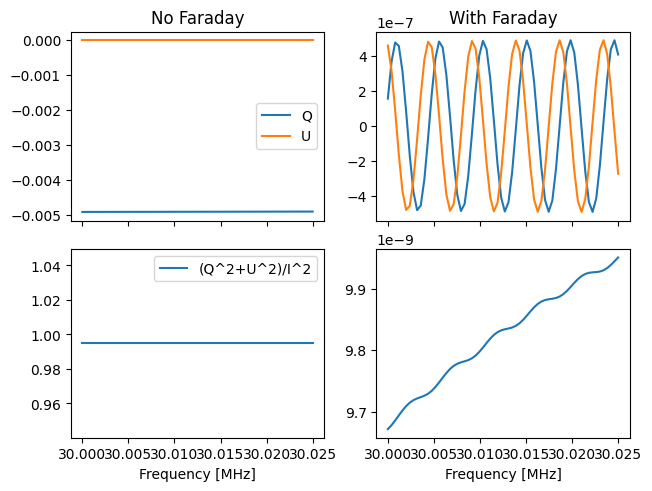

In [6]:
sim.run(channelize="wide")
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot, sharey="row")
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot, sharey=False)

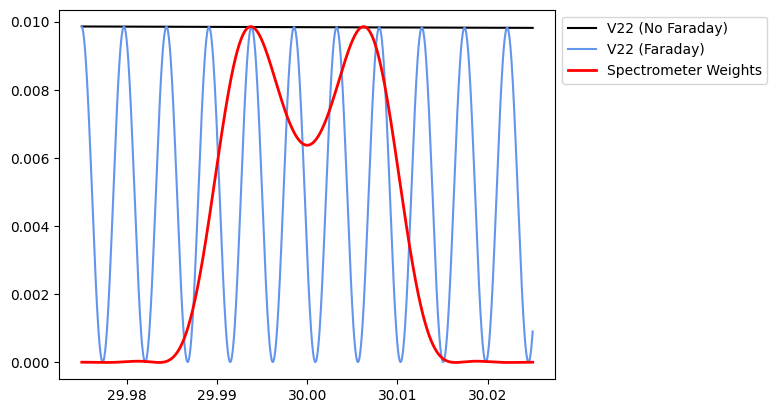

In [7]:
sim_freq = sim.freq[:, None] + sim.offset[None]
sim_freq = sim_freq.flatten()
#ix = sim_freq.argsort()
nbins = sim.offset.size

plt.figure()
plt.plot(sim_freq[:nbins], sim._vis[-1, :nbins], c="k", label="V22 (No Faraday)")
plt.plot(sim_freq[:nbins], sim._vis_rot[-1, :nbins], c="cornflowerblue", label="V22 (Faraday)")
plt.plot(sim_freq[:nbins], sim.wide_bin * sim._vis_rot[-1].max()/sim.wide_bin.max(), c="red", lw=2, label="Spectrometer Weights")
plt.legend(bbox_to_anchor=[1., 1.])
plt.show()

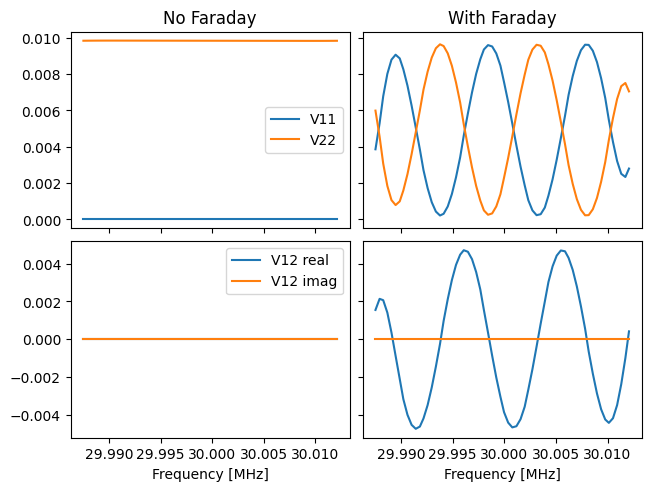

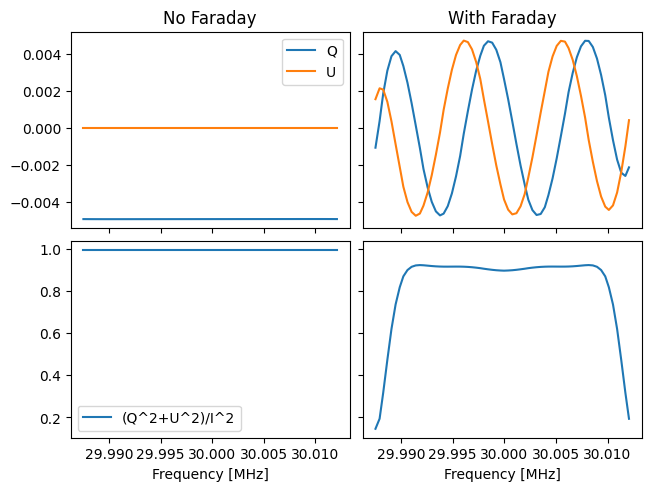

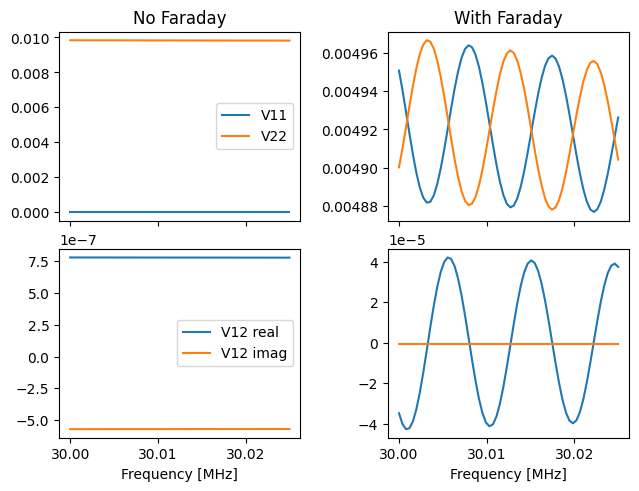

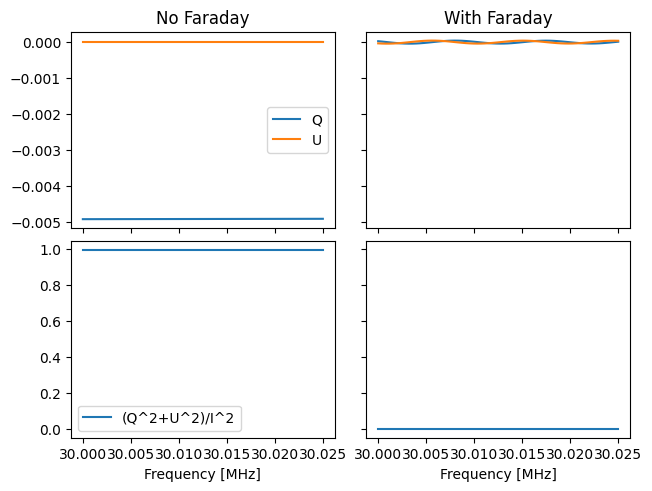

In [8]:
sim.run(channelize="narrow", RM=50)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

sim.run(channelize="wide", RM=50)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot, sharey=False)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

## 50 MHz

_beam.beam_X.shape=(2, 1, 196608)
_beam.beam_X.shape=(2, 1, 364)


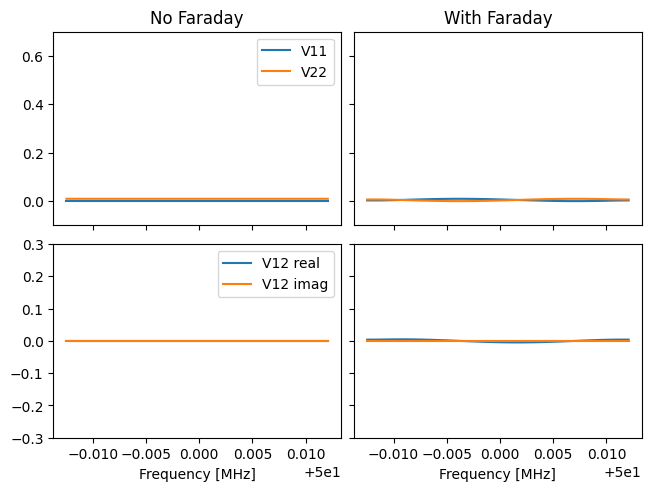

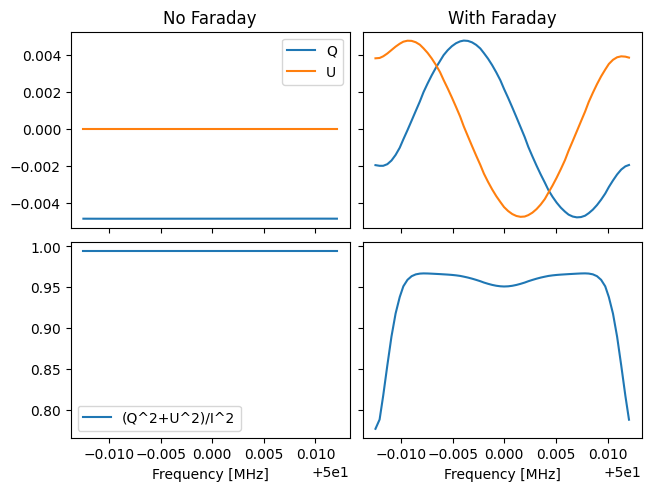

In [9]:
beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits", frequency=50)
sim = fd.Simulator(beam, sky, center_freq=50)
sim.run(channelize="narrow")
_, axs = fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot, return_fig=True)
plt.setp(axs[0], ylim=(-0.1, 0.7))
plt.setp(axs[1], ylim=(-0.3, 0.3))
plt.show()
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

_beam.beam_X.shape=(2, 1, 196608)
_beam.beam_X.shape=(2, 1, 364)


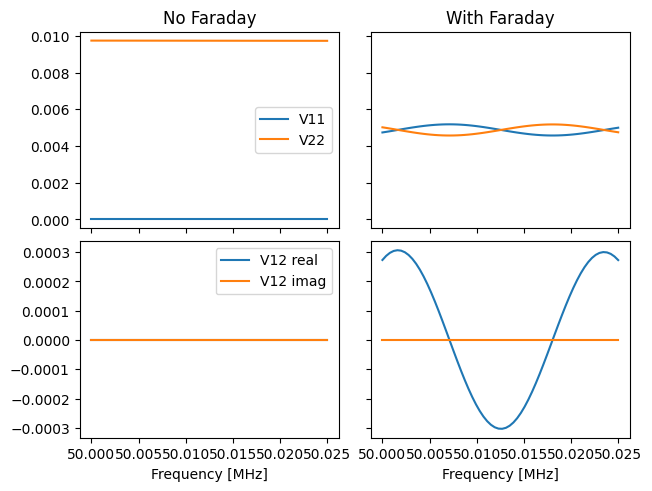

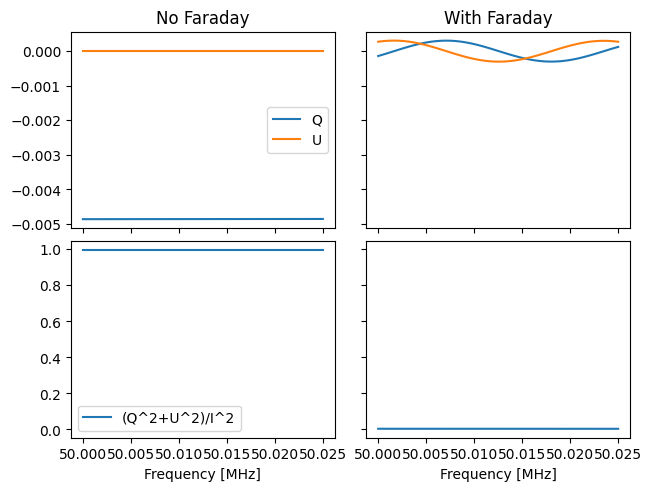

In [10]:
sim = fd.Simulator(beam, sky, center_freq=50)
sim.run(channelize="wide")
_, axs = fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot, return_fig=True)
#plt.setp(axs[0], ylim=(-0.1, 0.7))
#plt.setp(axs[1], ylim=(-0.3, 0.3))
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

## Off-center source

Instead of moving the source, we rotate the beam.

In [11]:
lat = 60
lon = 20

theta_src = np.deg2rad(90-lat)  # polar angle
phi_src = np.deg2rad(lon)
ct = np.cos(theta_src)
st = np.sin(theta_src)
cp = np.cos(phi_src)
sp = np.sin(phi_src)

x = st * cp
y = st * sp
z = ct

beta = np.arcsin(x)
gamma = np.arctan2(y/np.cos(beta), z/np.cos(beta))

rot = hp.Rotator(rot=(0, beta, gamma), deg=False)

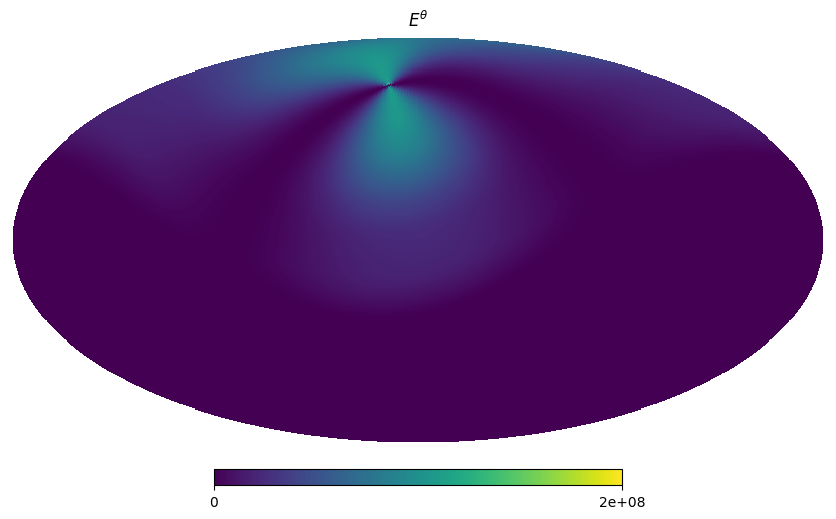

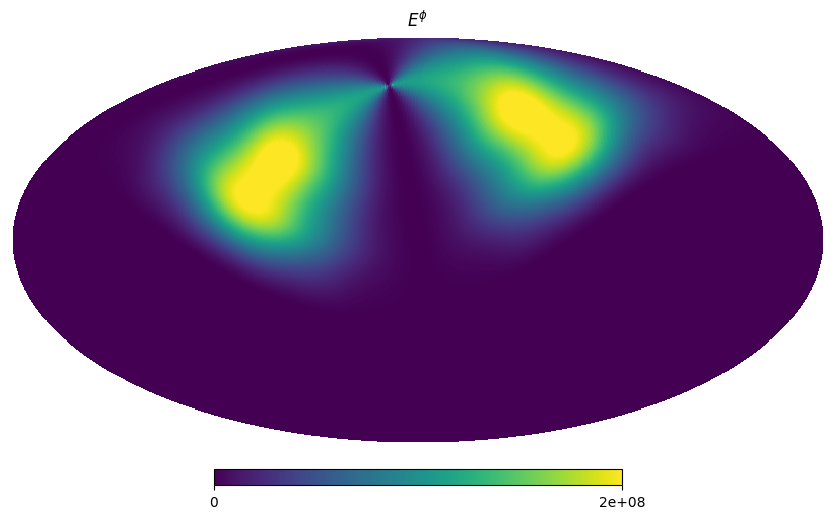

In [12]:
beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits")
beam.rotate(rot)
hp.mollview(np.abs(beam.beam_X[0, 0])**2, title="$E^{\\theta}$", min=0, max=2e8)
plt.show()
hp.mollview(np.abs(beam.beam_X[1, 0])**2, title="$E^{\\phi}$", min=0, max=2e8)
plt.show()

In [13]:
sky = fd.Sky.zeros()
sky.add_point_source()  # 5 deg source at zenith
# simulator expects sky at 23 GHz, not 30 MHz
sky.stokes = sky.stokes * (23e3/30)**(-2.5)

_beam.beam_X.shape=(2, 1, 196608)
_beam.beam_X.shape=(2, 1, 364)


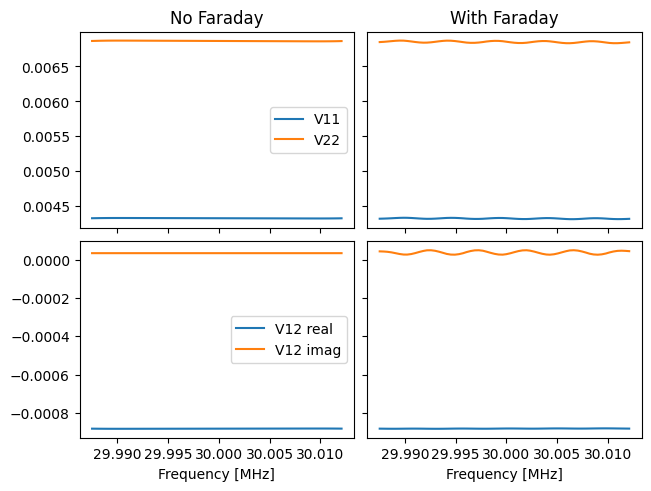

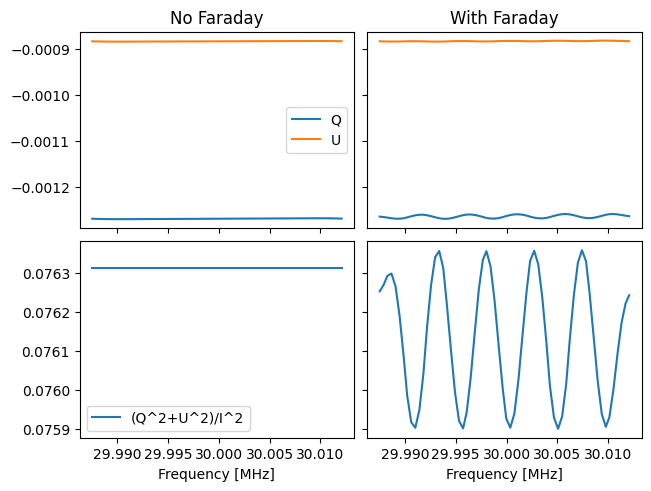

In [14]:
sim = fd.Simulator(beam, sky)
sim.run(channelize="narrow", src_frac=None)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

_beam.beam_X.shape=(2, 1, 196608)
_beam.beam_X.shape=(2, 1, 364)


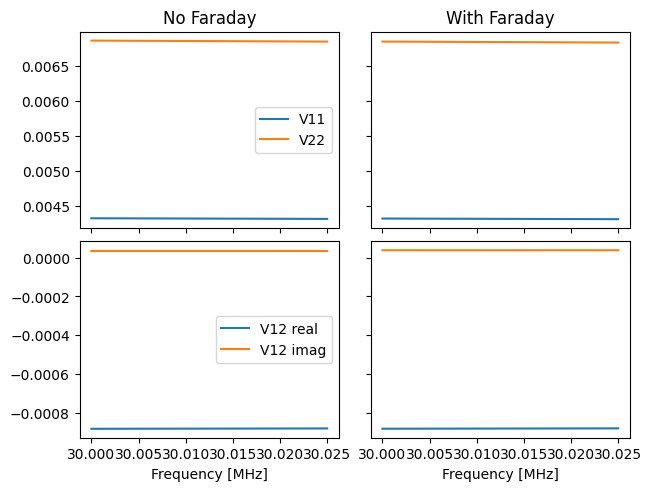

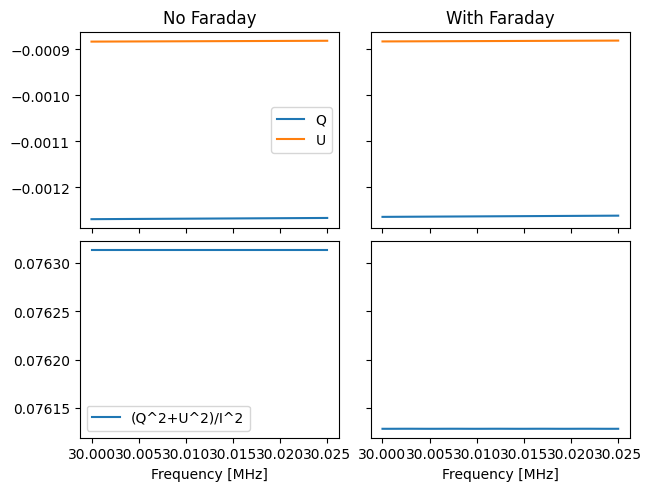

In [15]:
sim = fd.Simulator(beam, sky)
sim.run(channelize="wide")
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

## Testing Multi-Frequency Code...

In [16]:
sim = fd.Simulator(None, None, center_freq=30)
sim_freq = sim.offset + sim.center_freq

beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits", frequency=30)
sky = fd.Sky.zeros(freq=sim_freq)
sky.add_point_source()  # 5 deg source at zenith
# power law scaling from 30 MHz
sky.stokes = sky.stokes * (sim_freq[None, :, None]/30)**(-2.5)

In [17]:
sim = fd.Simulator(beam, sky, center_freq=30, full_map=True)

_beam.beam_X.shape=(2, 1, 196608)
_beam.beam_X.shape=(2, 1, 364)


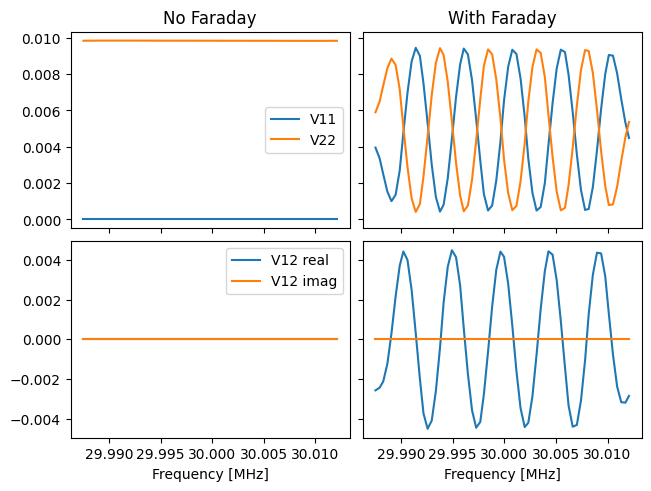

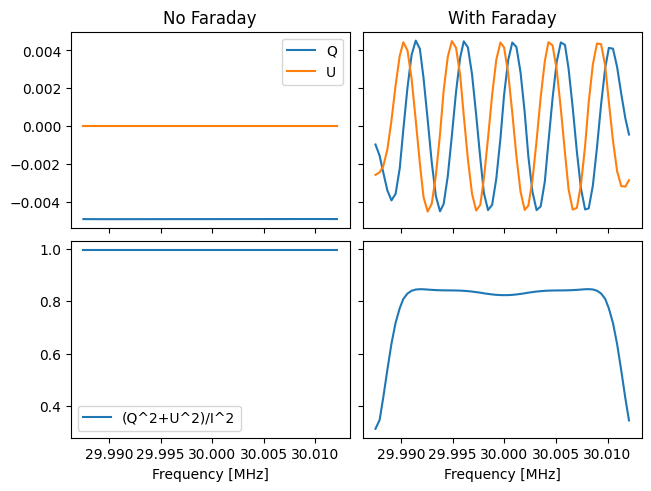

In [18]:
sim.run(channelize="narrow", src_frac=None)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

## Wmap

In [37]:
from astropy.io import fits
import healpy as hp
import h5py
import matplotlib.pyplot as plt
import numpy as np
from croissant.healpix import grid2healpix
import faraday as fd

#%matplotlib notebook

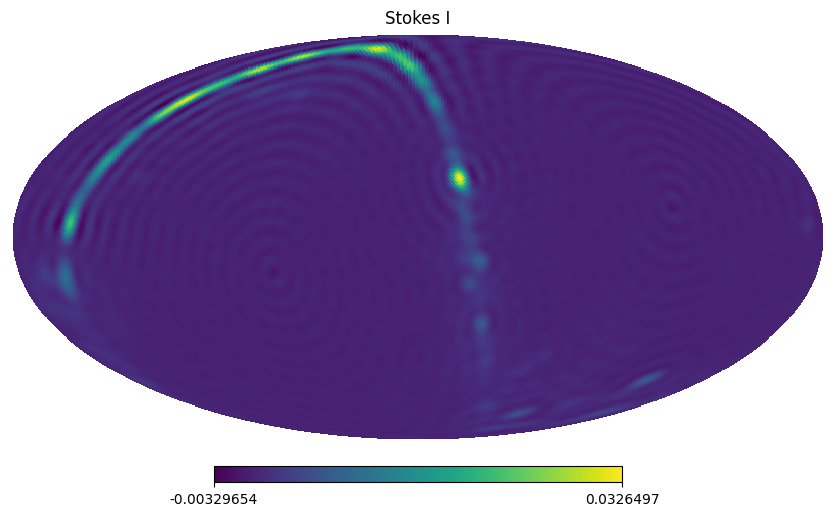

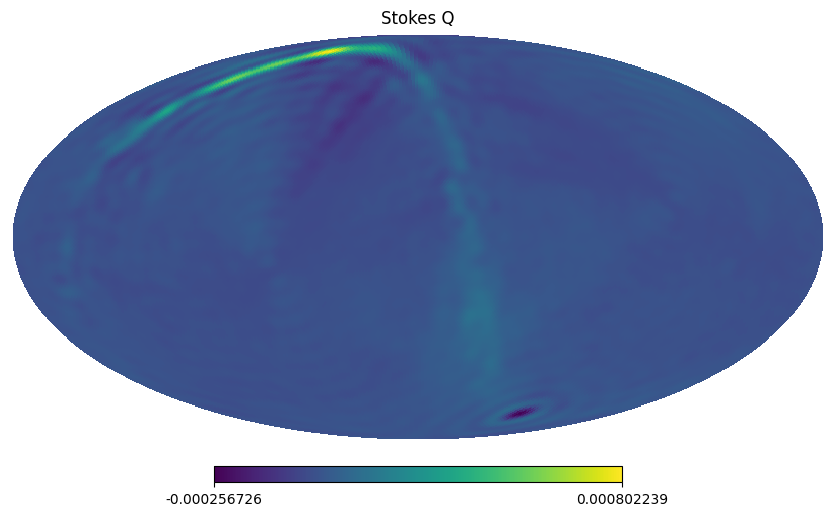

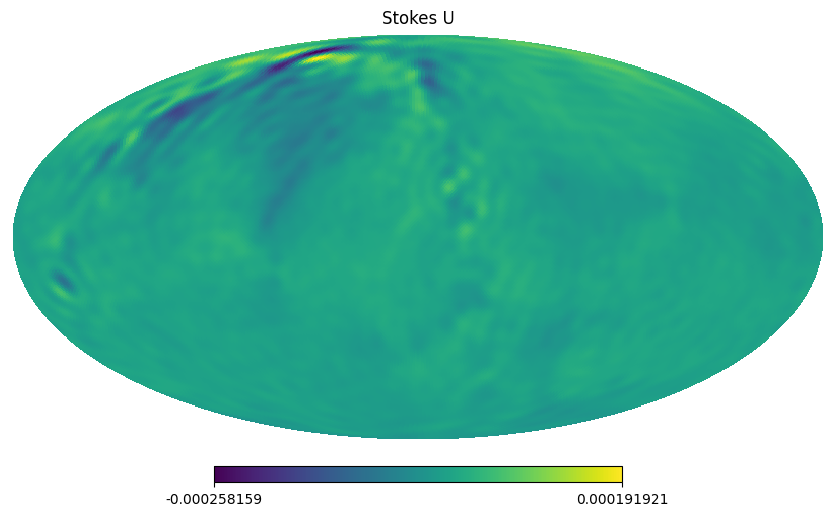

In [18]:
NSIDE = 64
LAT = -23.8
LON = 182.3
#TIME = "2026-01-01 09:00:00"
TIME = "2024-02-01 22:00:00"
sky = fd.Sky.wmap(nside=NSIDE)
sky.gal_to_topo(LAT, LON, TIME, moon=False)

hp.mollview(sky.stokes[0, 0], cbar=True, title="Stokes I")  # I
hp.mollview(sky.stokes[1, 0], cbar=True, title="Stokes Q")  # Q
hp.mollview(sky.stokes[2, 0], cbar=True, title="Stokes U")  # U

_beam.beam_X.shape=(2, 1, 49152)
_beam.beam_X.shape=(2, 1, 49152)


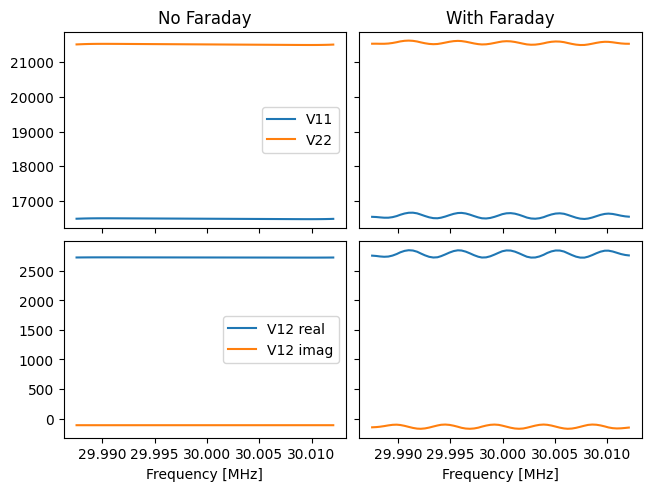

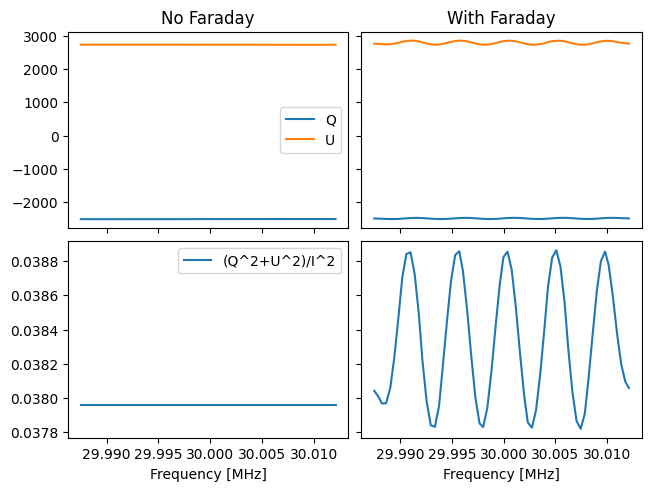

1.0888504165578055
0.15376153117884786
0.797515570132973
-1.5242593985138169
4.494372644338691


In [34]:
beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits", frequency=30, nside=NSIDE)
sim = fd.Simulator(beam, sky, center_freq=30, del_pix=False)
sim.run(channelize="narrow", src_frac=None)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

print(np.real(np.max(sim.vis_rot[0]) - np.min(sim.vis_rot[0])) / np.mean(sim.vis_rot[0].real) * 100)
print(np.real(np.max(sim.vis[0]) - np.min(sim.vis[0])) / np.mean(sim.vis[0].real) * 100)
print(np.real(np.max(sim.stokes_rot[0]) - np.min(sim.stokes_rot[0])) / np.mean(sim.stokes_rot[0].real) * 100)
print(np.real(np.max(sim.stokes_rot[1]) - np.min(sim.stokes_rot[1])) / np.mean(sim.stokes_rot[1].real) * 100)
print(np.real(np.max(sim.stokes_rot[-1]) - np.min(sim.stokes_rot[-1])) / np.mean(sim.stokes_rot[-1].real) * 100)

_beam.beam_X.shape=(2, 1, 49152)
_beam.beam_X.shape=(2, 1, 49152)


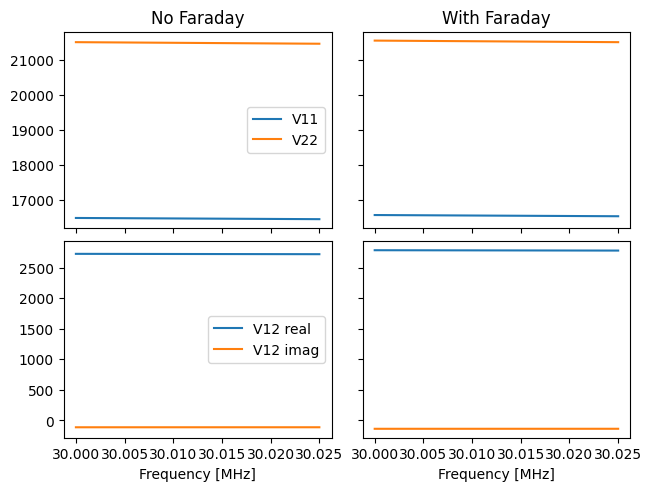

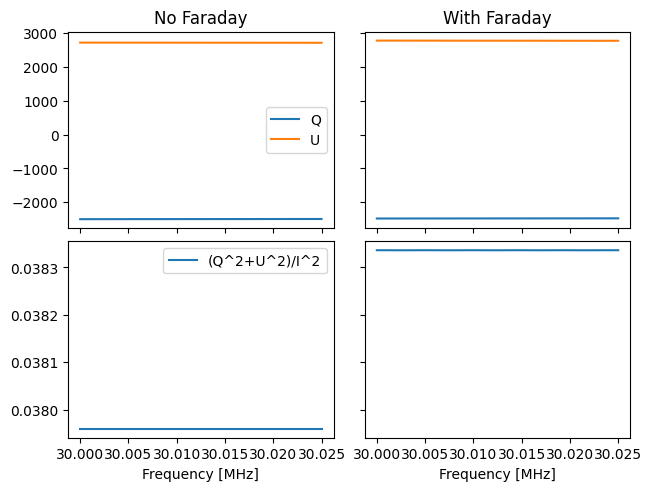

0.2082419805678892
0.20824664165332152
0.20825028933657458
-0.20830570617039523
0.2083062628055962


In [35]:
beam = fd.LuseeBeam("../data/hfss_lbl_3m_75deg.2port.fits", frequency=30, nside=NSIDE)
sim = fd.Simulator(beam, sky, center_freq=30, del_pix=False)
sim.run(channelize="wide", src_frac=None)
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

print(np.real(np.max(sim.vis_rot[0]) - np.min(sim.vis_rot[0])) / np.mean(sim.vis_rot[0].real) * 100)
print(np.real(np.max(sim.vis[0]) - np.min(sim.vis[0])) / np.mean(sim.vis[0].real) * 100)
print(np.real(np.max(sim.stokes_rot[0]) - np.min(sim.stokes_rot[0])) / np.mean(sim.stokes_rot[0].real) * 100)
print(np.real(np.max(sim.stokes_rot[1]) - np.min(sim.stokes_rot[1])) / np.mean(sim.stokes_rot[1].real) * 100)
print(np.real(np.max(sim.stokes_rot[-1]) - np.min(sim.stokes_rot[-1])) / np.mean(sim.stokes_rot[-1].real) * 100)

## Wmap sky + Hutschenreuter RM

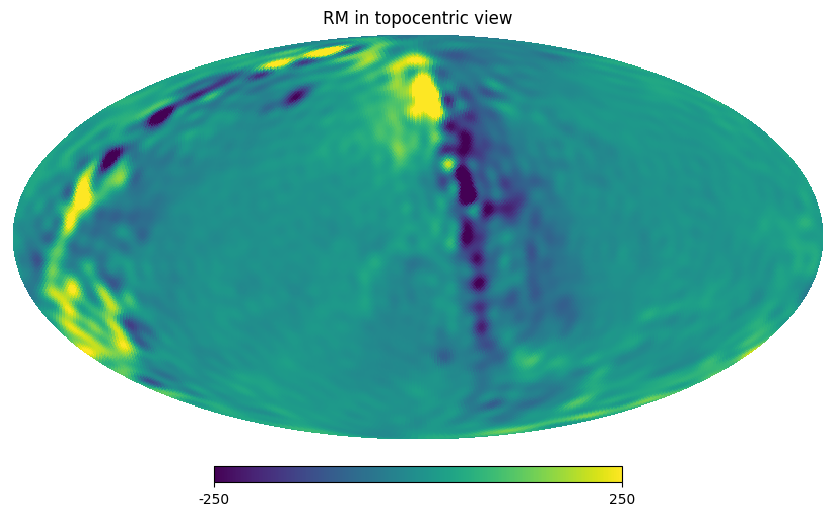

In [44]:
with h5py.File("../data/faraday2020v2.hdf5", "r") as f:
    f_depth = f["faraday_sky_mean"][:]  # faraday depth

f_depth = hp.ud_grade(f_depth, NSIDE)
f_depth = fd.Sky(stokes=np.array([[f_depth]]))
f_depth.gal_to_topo(LAT, LON, TIME, moon=False)
rm = f_depth.stokes[0, 0]
hp.mollview(rm, cbar=True, min=-250, max=250, title="RM in topocentric view")

In [57]:
# narrow
sim_freq = sim.offset + sim.center_freq
pl = (sim_freq / sim.ref_freq) ** (-2.5)
stokes = sim.sky.stokes * pl[None, :, None]
q = stokes[1]
u = stokes[2]
p = q + 1j * u
chi = np.array([fd.sky.pol_angle(sim_freq, rm_pix) for rm_pix in rm]).T
p_rot = p * np.exp(1j * 2 * chi)
stokes_rot = np.array([stokes[0], p_rot.real, p_rot.imag])
print(stokes.shape, stokes_rot.shape)

(3, 1000, 49152) (3, 1000, 49152)


In [68]:
sky = fd.Sky(stokes=stokes, freq=sim_freq)
sim = fd.Simulator(beam, sky, center_freq=30, del_pix=False)
sim.run(channelize="narrow", RM=0)

sky_rot = fd.Sky(stokes=stokes_rot, freq=sim_freq)
sim_rot = fd.Simulator(beam, sky_rot, center_freq=30, del_pix=False)
sim_rot.run(channelize="narrow", RM=0)

_beam.beam_X.shape=(2, 1, 49152)
_beam.beam_X.shape=(2, 1, 49152)
_beam.beam_X.shape=(2, 1, 49152)
_beam.beam_X.shape=(2, 1, 49152)


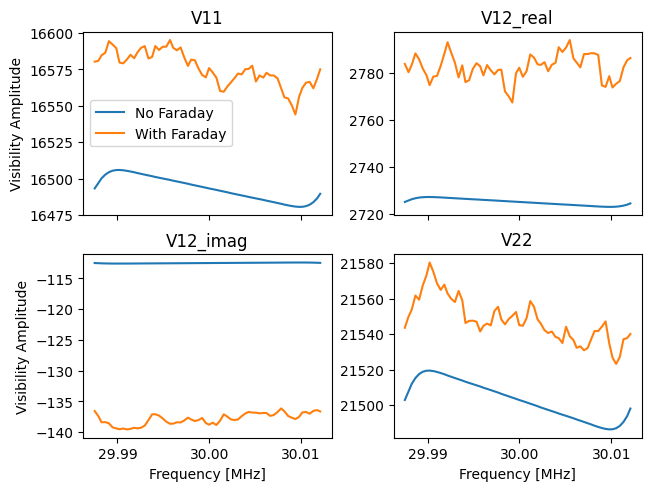

In [79]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, constrained_layout=True)
for i, t in zip([0, -1, 1, 2], ["V11", "V22", "V12_real", "V12_imag"]):
    ax = axs.ravel()[i]
    ax.plot(sim.freq, sim.vis[i], label="No Faraday")
    ax.plot(sim.freq, sim_rot.vis[i], label="With Faraday")
    ax.set_title(t)
axs[0, 0].legend()
for i in range(2):
    axs[1, i].set_xlabel("Frequency [MHz]")
    axs[i, 0].set_ylabel("Visibility Amplitude")
plt.show()

In [80]:
sim.stokes.shape

(3, 64)

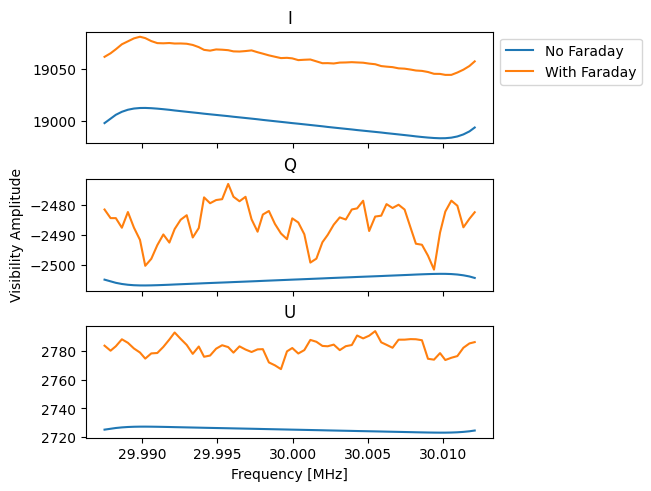

In [83]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, constrained_layout=True)
for i, t in zip(range(3), ["I", "Q", "U"]):
    ax = axs.ravel()[i]
    ax.plot(sim.freq, sim.stokes[i], label="No Faraday")
    ax.plot(sim.freq, sim_rot.stokes[i], label="With Faraday")
    ax.set_title(t)
axs[0].legend(bbox_to_anchor=[1.,1.])
axs[1].set_ylabel("Visibility Amplitude")
axs[2].set_xlabel("Frequency [MHz]")
plt.show()